### Display YOLO results

This notebook shows the results of the YOLO network on our data.

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import TensorDataset, DataLoader
from helpers.ML_helper import *
import h5py
from skimage.transform import rotate, resize, rescale
from helpers.corrections import *
from helpers.ML_helper import *

from PIL import Image
import ultralytics
ultralytics.checks()


relevant_characters =  {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'B',10:'F',11:'G',12:'K',13:'N',14:'O',15:'P',16:'R',17:'S',18:'V',19:'W',20:'Y', 21:''}

Ultralytics YOLOv8.0.189  Python-3.11.3 torch-2.0.1+cpu CPU (AMD Ryzen 5 3600 6-Core Processor)
Setup complete  (12 CPUs, 16.0 GB RAM, 181.9/465.1 GB disk)


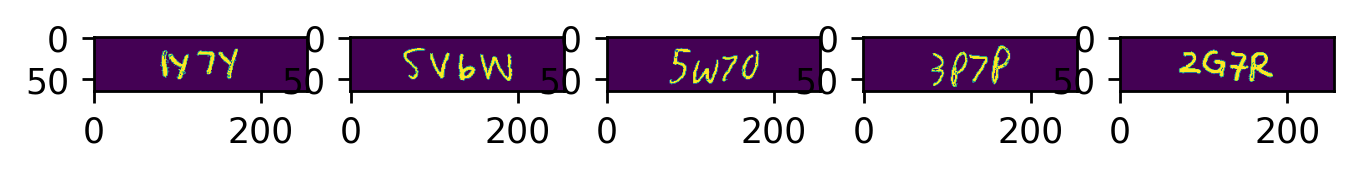

In [3]:
f = h5py.File('test_dataset.h5','r')
fig,ax = plt.subplots(1,5,dpi=250)

j = 0
i= 1000
for i in np.arange(i, i + 5):
    ax[j].imshow(f['images'][i])
    j += 1

In [4]:
# Load the data, and save the IDs as images (so they can be put into model)

a = f['images']

a_labels = np.array(f['labels'])
a_labels_chars = np.array([vector_to_string(a_labels[i],relevant_characters) for i in range(len(a_labels))])

a_labels_goog = np.array(f['labels_googpred'])
a_labels_goog_chars = np.array([vector_to_string(a_labels_goog[i],relevant_characters) for i in range(len(a_labels_goog))])

images_prefix = "../YOLOdata/test/"

store_filenames = []

for exno,img in enumerate(a):
    img = (((img - img.min()) / (img.max() - img.min())) * 255.9)

    img = Image.fromarray(np.uint8(img))
    img = img.convert("L")

    filename = images_prefix + f"im{exno}.jpg"
    img.save(filename)
    store_filenames.append(filename)

In [5]:
from ultralytics import YOLO
model_let = YOLO('../YOLOdata/YOLOletters.pt')
model_num = YOLO('../YOLOdata/YOLOnumbers.pt')

In [7]:
letter_result = model_let.predict('../../Guppies_Main/test.jpg')
number_result = model_num.predict('../../Guppies_Main/test.jpg')
letter_data = letter_result[0].boxes.data.detach().clone()
letter_data[:,-1] = letter_data[:,-1] + 9
number_data = number_result[0].boxes.data.detach().clone()

data = torch.cat((letter_data, number_data), dim=0)
idx_data = torch.arange(data.shape[0], dtype=torch.int)

order = torch.argsort(data[:,0],dim=0)
data = data[order] 
idx_data = idx_data[order]

print(data)
print(idx_data)


image 1/1 c:\Users\newc6448\Projects\Guppies\Python_Files\..\..\Guppies_Main\test.jpg: 96x256 (no detections), 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 96, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Python_Files\..\..\Guppies_Main\test.jpg: 96x256 1 1, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.0ms postprocess per image at shape (1, 3, 96, 256)


tensor([[223.1918, 161.9303, 253.0364, 209.6187,   0.3164,   1.0000]])
tensor([0], dtype=torch.int32)


In [8]:
results_let = [model_let.predict(img)[0] for img in store_filenames] #run the models on each image. Note this step takes like 0.5 seconds per image on my pc
results_num = [model_num.predict(img)[0] for img in store_filenames]


image 1/1 c:\Users\newc6448\Projects\Guppies\Python_Files\..\YOLOdata\test\im0.jpg: 64x256 1 B, 1 K, 27.0ms
Speed: 1.0ms preprocess, 27.0ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Python_Files\..\YOLOdata\test\im1.jpg: 64x256 1 B, 1 R, 27.0ms
Speed: 0.0ms preprocess, 27.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Python_Files\..\YOLOdata\test\im2.jpg: 64x256 1 B, 1 W, 26.0ms
Speed: 0.0ms preprocess, 26.0ms inference, 0.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Python_Files\..\YOLOdata\test\im3.jpg: 64x256 1 P, 2 Ys, 25.0ms
Speed: 0.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Python_Files\..\YOLOdata\test\im4.jpg: 64x256 2 Ys, 28.0ms
Speed: 0.0ms preprocess, 28.0ms inference, 1.0ms postprocess per image at 

In [9]:
def box_to_rectangle(box, color='r', linewidth=0.2):
    from matplotlib.patches import Rectangle
    rect = Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=linewidth, edgecolor=color, facecolor='none')
    return rect

def analyse_results(letter_data, number_data, prob_threshold):

    #first bring together the letters and numbers.

    letter_data = letter_data.detach().clone()
    letter_data[:,-1] = letter_data[:,-1] + 9 #add 9 to the class of the letters to make them different from the numbers

    no_letters = len(letter_data)
    data = torch.cat((letter_data, number_data), dim=0) #combine the two tensors
    idx_data = torch.arange(data.shape[0], dtype=torch.int) #create an index tensor

    #discard characters with low probability
    keep = data[:,-2] > prob_threshold
    data = data[keep] 
    idx_data = idx_data[keep]

    #sort by x coordinate to get the right order
    orde = torch.argsort(data[:,0],dim=0)
    data = data[orde] 
    idx_data = idx_data[orde]

    
    if data.shape[0] > 0:
        #discard any characters that are too short?
        height_threshold = (data[:,3] - data[:,1]).max() * 0.5
        
        keep = data[:,3] - data[:,1] > height_threshold
        data = data[keep]
        idx_data = idx_data[keep] 

        data, idx_data = discard_overlapping_boxes(data, idx_data) #discard overlapping boxes
        
    probs = data[:,-2].numpy()
    classes = data[:,-1].to(torch.int).numpy()

    boxes = data[:,:-2].numpy().astype(int)
    
    letter_idxs = torch.where(idx_data < no_letters)[0]
    return boxes, classes, probs, letter_idxs
    

def discard_overlapping_boxes(data, idx_data):
    #if the model predicted two characters that overlap alot, then remove the smaller one?

    intersections = np.array([len(list(range(max(int(data[i,0]), int(data[i+1,0])), min(int(data[i,2]), int(data[i+1,2]))+1))) for i in range(data.shape[0]-1)])#get the x intersection between each box
    area = (data[:,2]-data[:,0])*(data[:,3]-data[:,1])

    x_ranges = data[:,2]-data[:,0]

    x_ranges = np.array([torch.min(x_ranges[i],x_ranges[i+1]) for i in range(x_ranges.shape[0]-1)])

    intersections = intersections/x_ranges

    problemos = np.where(intersections>0.3)[0] #if 0.3 of a letter 

    for n in range(len(problemos)):
        i = problemos[n]
        if area[i] < area[i+1]:
            data = np.delete(data, i, axis=0)
            idx_data = np.delete(idx_data, i, axis=0)
        else:
            data = np.delete(data, i+1, axis=0)
            idx_data = np.delete(idx_data, i+1, axis=0)
        problemos = problemos - 1

    return data, idx_data

In [10]:
boxes, classes, probs, letter_idx = analyse_results(results_let[0].boxes.data, results_num[0].boxes.data, prob_threshold = 0.3)


In [11]:
preds = []
googpreds = []

all_boxes = []
prob_threshold = 0.5

for i in range(len(a)):
    boxes, pred_vec, probs, letter_idx = analyse_results(results_let[i].boxes.data,results_num[i].boxes.data, prob_threshold) #analyse each prediction.
    chars = np.array(vector_to_string(pred_vec,char_dict = relevant_characters)) #change the vectorised predictions to strings
    true_string = ''.join(a_labels_chars[i])
    pred_string = ''.join(chars)
    pred_string = IdentityErrors(pred_string)

    goog_string = ''.join(a_labels_goog_chars[i])


    if pred_string == 1:
        pred_string = '1'

    classes = string_to_vector(pred_string, relevant_characters)
    goog_classes = string_to_vector(goog_string, relevant_characters)
    
    preds.append(classes)
    googpreds.append(goog_classes)
    all_boxes.append(boxes)

preds = np.array(preds)
googpreds = np.array(googpreds)

Plot them

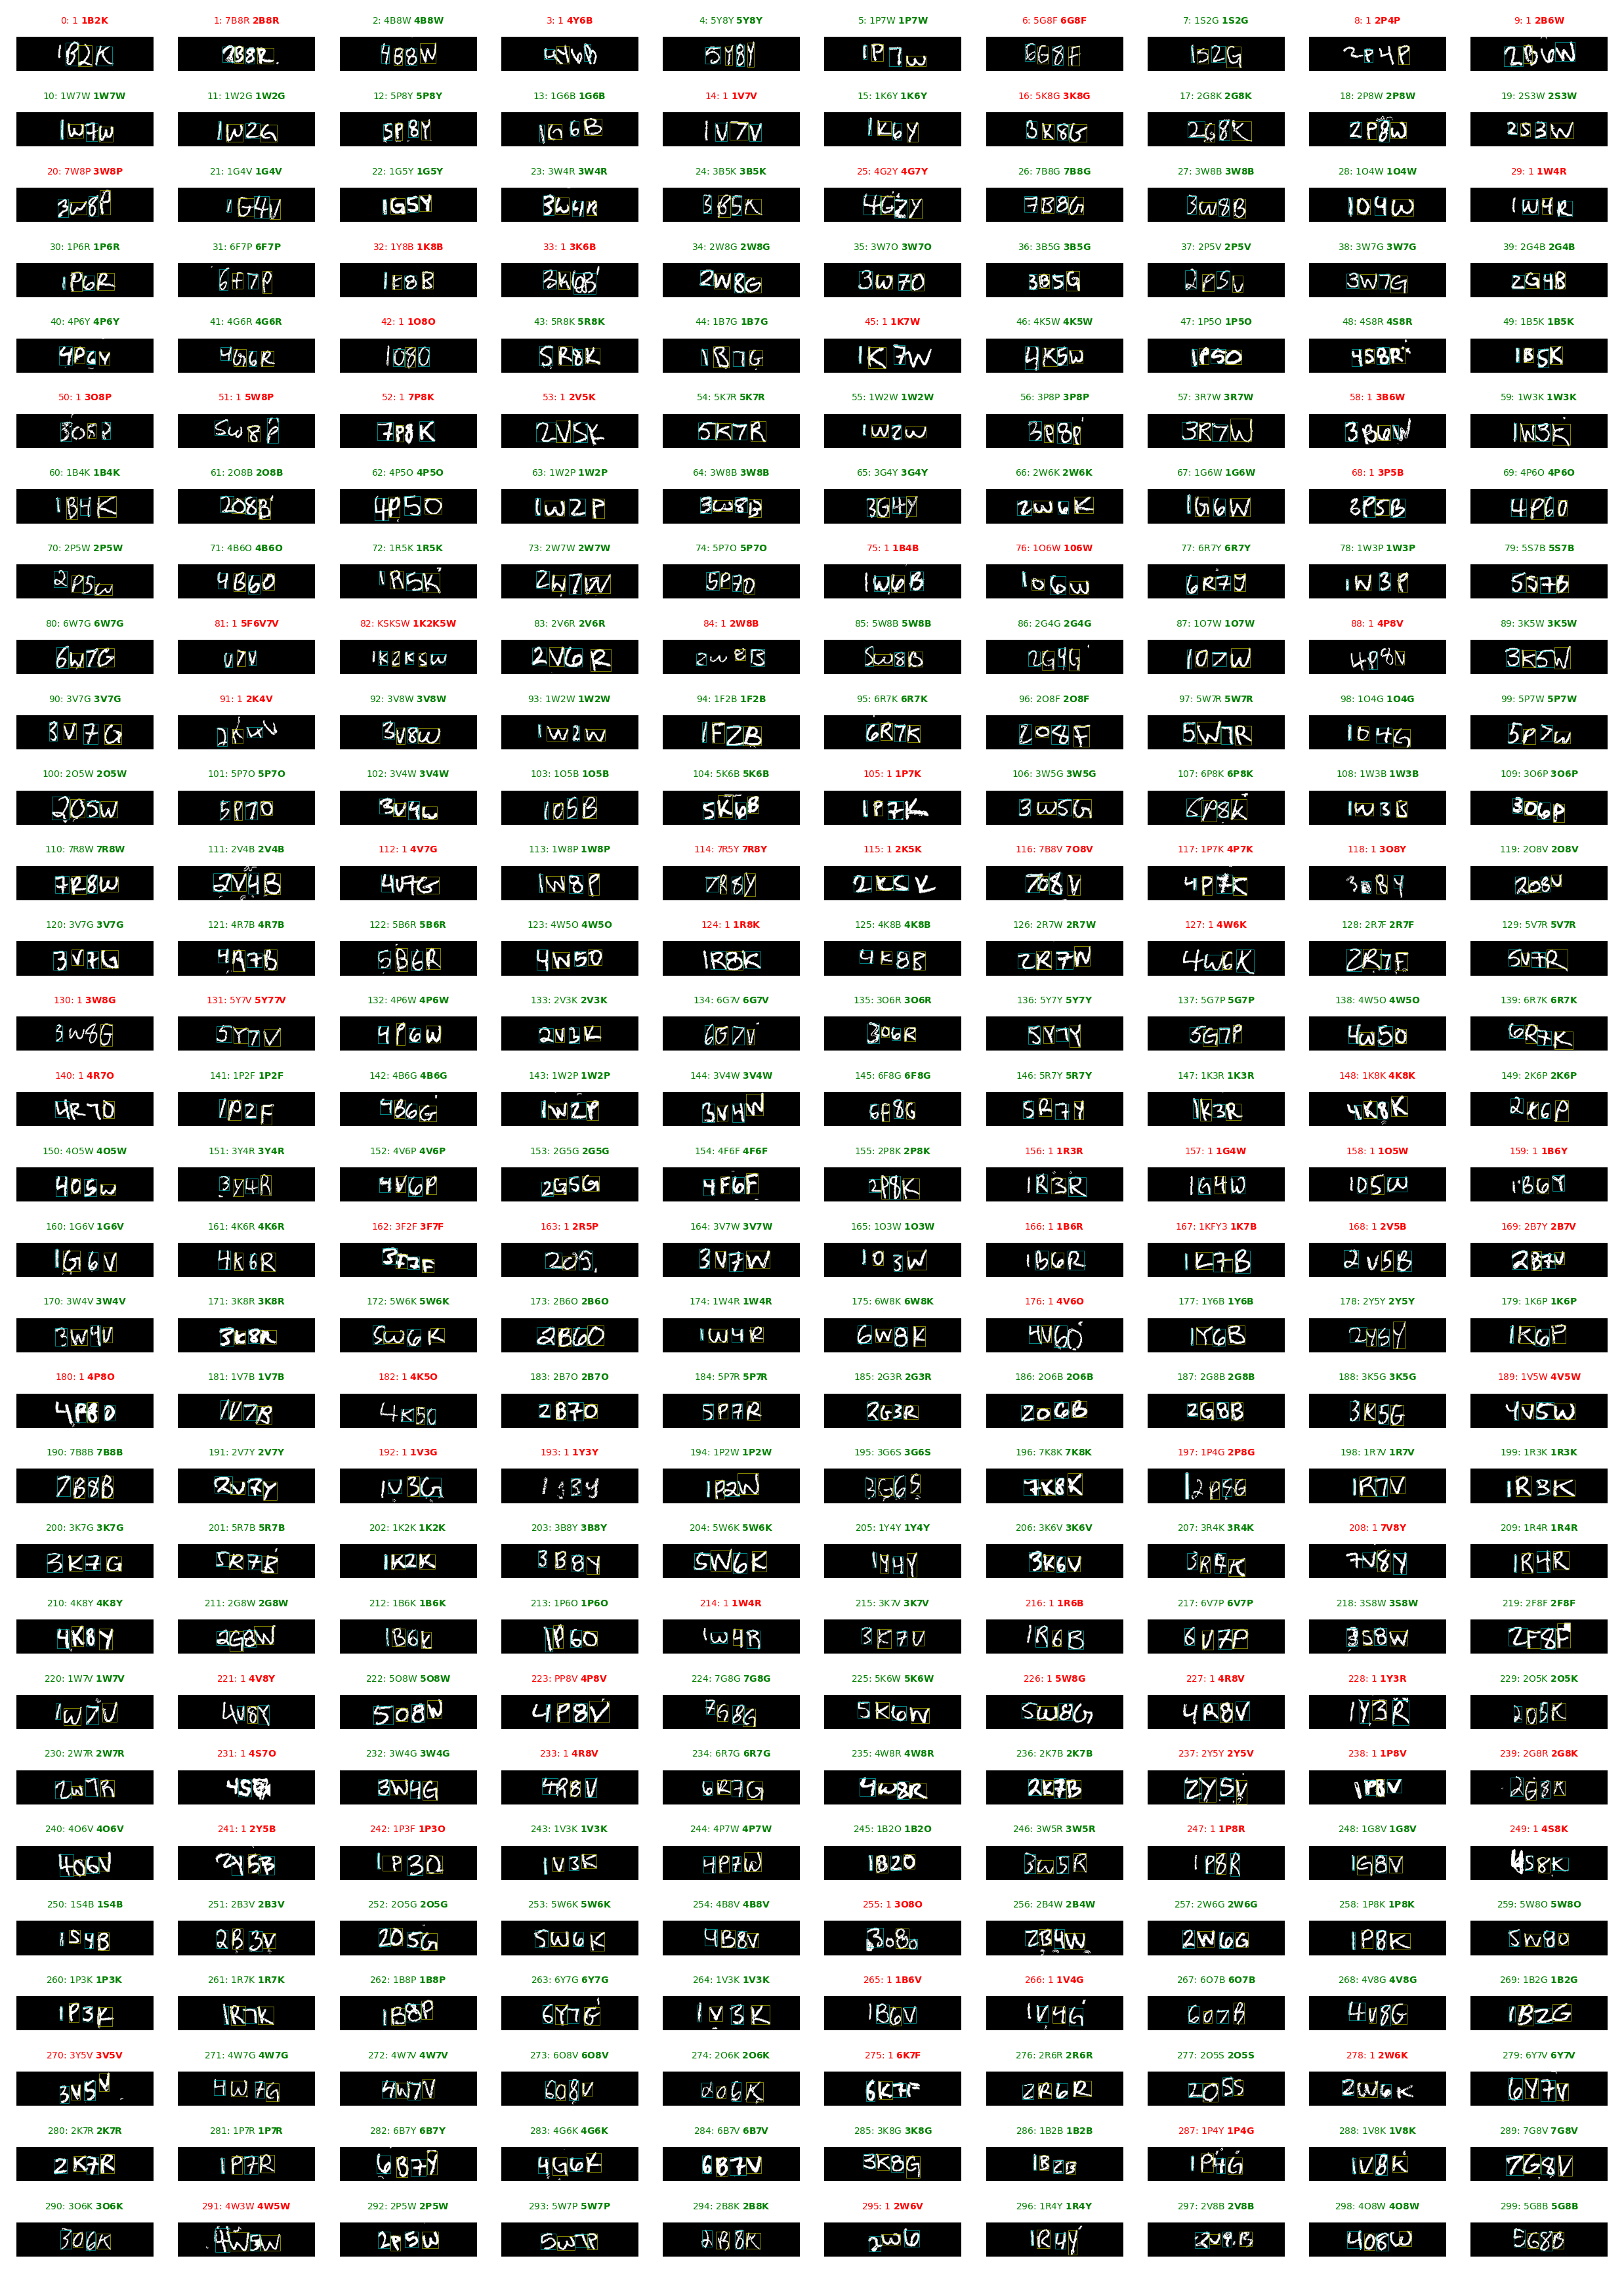

In [12]:
fig,ax = plt.subplots(30,10,figsize = (10,14),dpi=250)

true_labels = a_labels



for i in range(300):

    x,y = i//10,i%10
    ax[x,y].imshow(a[i], cmap='gray'); ax[x,y].axis('off')


    boxes = all_boxes[i]

    for n,box in enumerate(boxes):
        if n in letter_idx:
            rect = box_to_rectangle(box,color='y')
        else: rect = box_to_rectangle(box,color='c')
        ax[x,y].add_patch(rect)

    true_string = ''.join(a_labels_chars[i])
    pred_string = ''.join(vector_to_string(preds[i], relevant_characters))

    color = 'green' if true_string==pred_string else 'red'

    # put together the results.    
    ax[x,y].set_title(str(i) + ': ' +pred_string +' ' + r"$\bf{" + true_string + "}$" ,color = color,fontsize=4)
    

plt.tight_layout()
plt.show()

# final_preds = np.zeros((len(preds),8))
# final_googpreds = np.zeros((len(preds),8))

# problems = []
# for i in range(len(preds)):
#     final_preds[i] = np.append(preds[i],np.ones(8-len(preds[i])) * 21) #21 is a token for a space
#     final_googpreds[i] = np.append(googpreds[i],np.ones(8-len(googpreds[i])) * 21) #21 is a token for a space

In [13]:
# correct_len = np.sum(true_labels == 21, axis=1) == np.sum(final_preds == 21, axis=1)
correct_len = np.sum(preds == 21, axis=1) <= 4 #just discard anything where there was less than 4 predictions
print("Percentage of useful predictions: ", np.sum(correct_len) / len(preds) * 100 , "%")

Percentage of useful predictions:  83.5493965131873 %


In [14]:
rightlengthpreds = preds[correct_len]#np.delete(final_preds,problems,axis=0)
rightlengthlabels = true_labels[correct_len] #np.delete(true_labels,problems,axis=0)
rightlengthgoogle = googpreds[correct_len]

print('##############  YOLO  ##############')

print(f'accuracy on fullset: {np.sum(np.sum(preds - true_labels, axis=1) == 0) / len(preds)}')
print(f'accuracy on rightlengthset: {np.sum(np.sum(rightlengthpreds - rightlengthlabels, axis=1) == 0) / len(rightlengthlabels)}')

print('##############  GOOGLE  ##############')

print(f'accuracy on fullset: {np.sum(np.sum(googpreds - true_labels, axis=1) == 0) / len(preds)}')
print(f'accuracy on rightlengthset: {np.sum(np.sum(rightlengthgoogle - rightlengthlabels, axis=1) == 0) / len(rightlengthlabels)}')

##############  YOLO  ##############
accuracy on fullset: 0.7335717478766205
accuracy on rightlengthset: 0.8780096308186196
##############  GOOGLE  ##############
accuracy on fullset: 0.7429593205185516
accuracy on rightlengthset: 0.7560192616372392


### First i wanna look at which characters each model consistently gets

In [15]:
yolo_confusion = np.zeros((len(relevant_characters),len(relevant_characters)))
google_confusion = np.zeros((len(relevant_characters),len(relevant_characters)))

for i in range(len(rightlengthpreds)):#
    for n in range(len(rightlengthpreds[i])):
        yolo_confusion[rightlengthlabels[i,n],int(rightlengthpreds[i,n])] += 1
        google_confusion[rightlengthlabels[i,n],int(rightlengthgoogle[i,n])] += 1

yolo_confusion[-1,-1] = 0
google_confusion[-1,-1] = 0

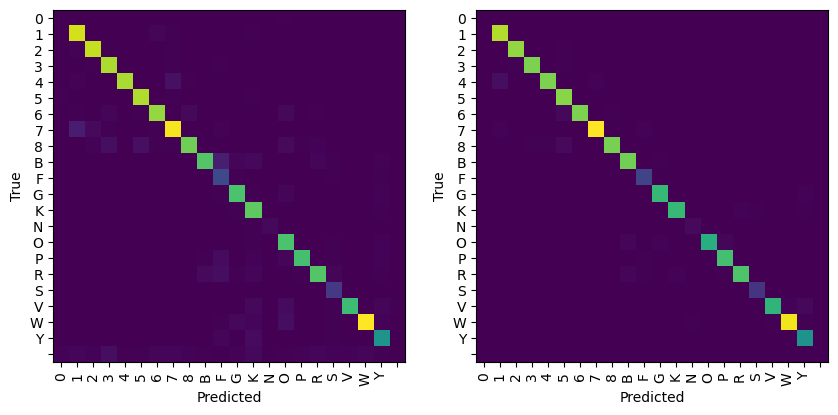

In [16]:
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(google_confusion)

ax[1].imshow(yolo_confusion)

for j in range(2):
    ax[j].set_xticks([i for i in range(len(relevant_characters))])
    ax[j].set_xticklabels(list(relevant_characters.values()),rotation=90);
    ax[j].set_yticks([i for i in range(len(relevant_characters))])
    ax[j].set_yticklabels(list(relevant_characters.values()));
    ax[j].set_xlabel('Predicted')
    ax[j].set_ylabel('True')


### Lets analyse the ones YOLO got wrong

(maybe we should just look at each character and which model gets it right typically)

In [14]:
wrongs = np.where(np.sum(rightlengthpreds - rightlengthlabels, axis=1) != 0)[0]

In [15]:
wrongcharacters = np.empty((0,5)) #pred, label, googpred, characterposition, idx

for i in range(len(wrongs)):
    idx = wrongs[i]
    test = rightlengthpreds[idx] == rightlengthlabels[idx]

    if sum(test) == 8:
        continue
    else:
        bads = np.where(test == False)[0]
        for badchar in bads:
            wrongcharacters = np.append(wrongcharacters, [[rightlengthpreds[idx][badchar], rightlengthlabels[idx][badchar], rightlengthgoogle[idx][badchar], badchar, idx]], axis=0)


In [18]:
def synthesise_google_yolo(yolopred, googlepred, relevant_characters):

    k = list(relevant_characters.values()).index('K')
    r = list(relevant_characters.values()).index('R')
    y = list(relevant_characters.values()).index('Y')
    v = list(relevant_characters.values()).index('V')

    finalpred = yolopred
    for charno in range(len(finalpred)):
        if ((finalpred[charno] == 1) and (googlepred[charno] == 4)):
            finalpred[charno] = 4

        if ((finalpred[charno] == k) and (googlepred[charno] == r)):
            finalpred[charno] = r

        if ((finalpred[charno] == y) and (googlepred[charno] == v)):
            finalpred[charno] = v

    return finalpred




In [19]:
ammended_preds = np.array([synthesise_google_yolo(rightlengthpreds[i],rightlengthgoogle[i], relevant_characters) for i in range(len(rightlengthpreds))])

In [20]:
print(f'accuracy on rightlengthset: {np.sum(np.sum(ammended_preds - rightlengthlabels, axis=1) == 0) / len(rightlengthlabels)}')

accuracy on rightlengthset: 0.8966613672496025


In [22]:
for row in wrongcharacters:
    print(vector_to_string(row[:3], relevant_characters), row[3], row[4])
    

['5', '6', '5'] 2.0 1.0
['P', 'O', 'O'] 1.0 9.0
['F', '7', '7'] 2.0 17.0
['P', 'F', 'F'] 1.0 19.0
['8', '6', '6'] 2.0 19.0
['2', '1', '1'] 0.0 25.0
['V', 'S', 'S'] 1.0 25.0
['7', '2', '2'] 2.0 25.0
['', '7', '7'] 4.0 25.0
['', 'V', 'O'] 5.0 25.0
['V', '4', '4'] 0.0 26.0
['B', 'S', 'F'] 1.0 66.0
['7', '5', '5'] 0.0 92.0
['B', 'R', 'B'] 3.0 92.0
['7', '2', '2'] 0.0 94.0
['Y', 'G', 'G'] 3.0 100.0
['5', '8', '8'] 2.0 101.0
['B', 'P', 'F'] 3.0 148.0
['B', 'R', 'B'] 1.0 154.0
['G', 'F', 'F'] 3.0 160.0
['F', '6', '6'] 4.0 160.0
['', 'F', 'F'] 5.0 160.0
['O', '6', '6'] 2.0 169.0
['Y', 'W', 'O'] 3.0 176.0
['G', 'B', 'B'] 3.0 212.0
['F', 'S', 'S'] 1.0 213.0
['R', 'B', 'R'] 3.0 218.0
['V', 'W', 'W'] 1.0 241.0
['P', 'O', 'O'] 1.0 249.0
['P', 'O', 'O'] 1.0 253.0
['3', '6', '1'] 2.0 253.0
['5', '8', 'P'] 2.0 257.0
['B', 'R', 'B'] 1.0 261.0
['O', 'G', 'O'] 3.0 262.0
['6', '', '6'] 4.0 262.0
['F', 'S', 'G'] 1.0 265.0
['5', '3', '3'] 2.0 268.0
['5', '8', 'O'] 2.0 301.0
['B', 'R', 'F'] 1.0 315.0
['0', '

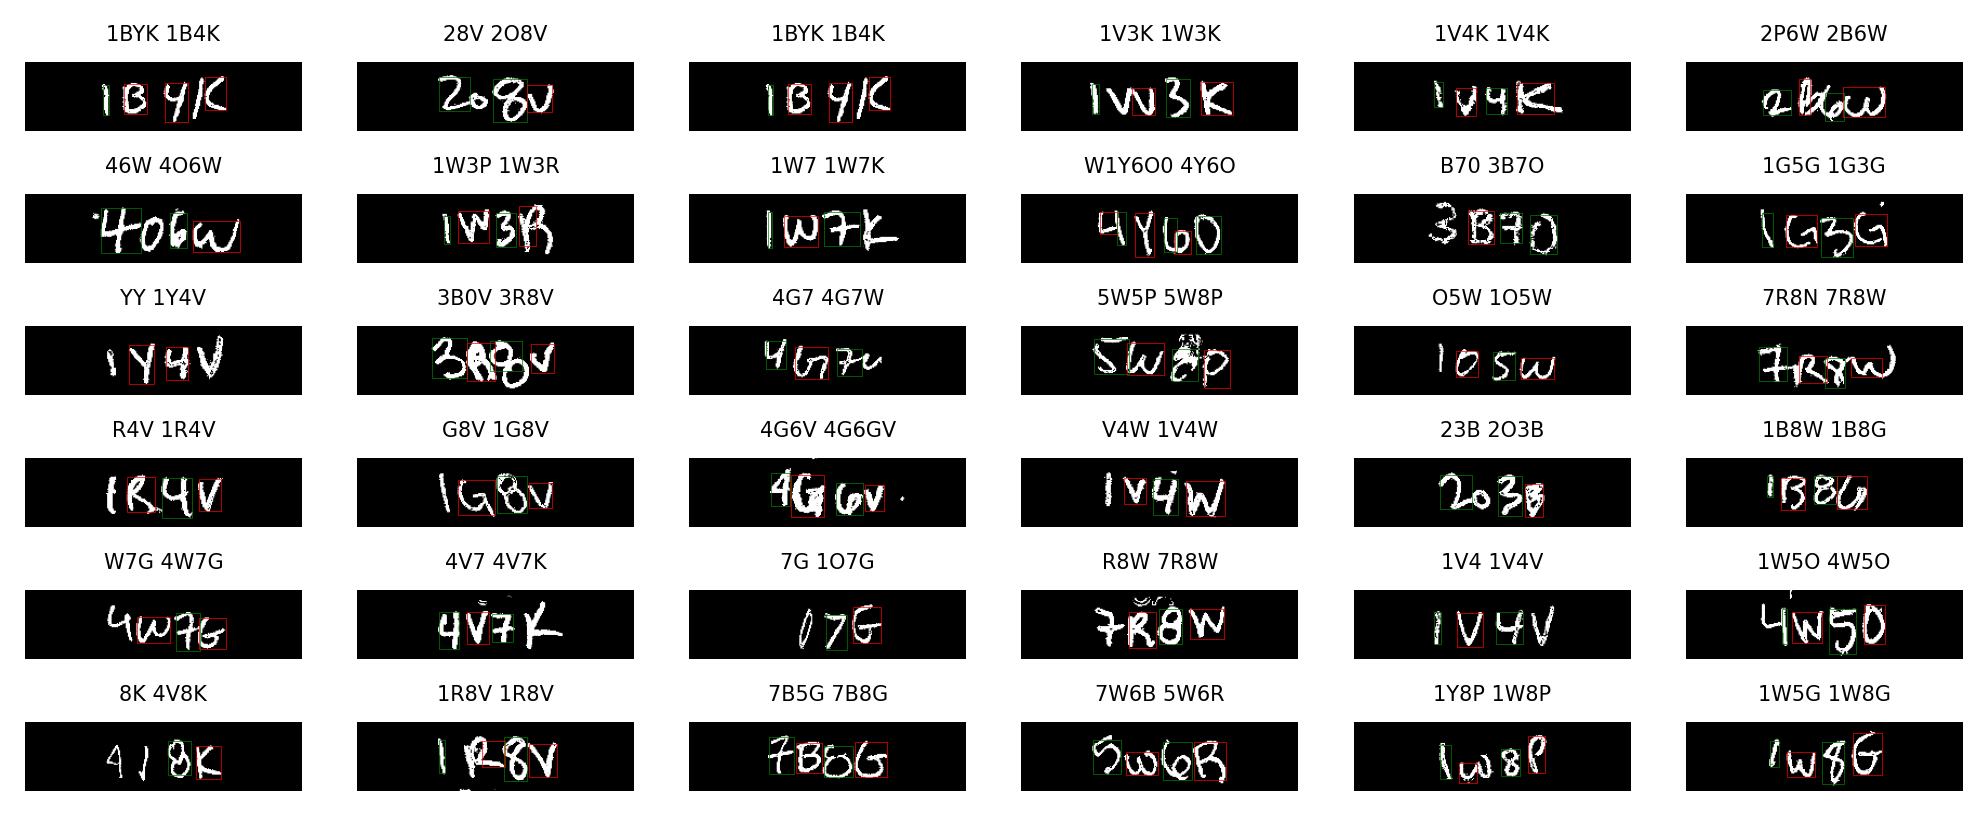

In [ ]:
fig,ax = plt.subplots(6,6,figsize=(10,4),dpi=250)

prob_threshold = 0.2
for i in range(36):

    x,y = i%6,i//6

    j = wrongs[i]
    ax[x,y].imshow(a[j], cmap='gray'); ax[x,y].axis('off')

    boxes, classes, probs, letter_idx = analyse_results(results_let[j].boxes.data,results_num[j].boxes.data, prob_threshold)

    for n,box in enumerate(boxes):
        if n in letter_idx:
            rect = box_to_rectangle(box,color='r')
        else: rect = box_to_rectangle(box,color='g')

        ax[x,y].add_patch(rect)

    chars = np.array(id_to_char(classes,keys_list = relevant_characters))

    true_string = ''.join(a_labels_chars[j])
    pred_string = ''.join(chars)

    # put together the results.    
    ax[x,y].set_title(pred_string +' ' + true_string,fontsize=6)

    
    #print(f'image {i}')
    # for n in range(len(chars)):
    #     print('Character: ',chars[n], '  Confidence: ', probs[n])

plt.show()


In [ ]:
cnn_let = torch.load('letter_model.pth')
cnn_num = torch.load('number_model.pth')

In [ ]:
from skimage.transform import rescale

In [ ]:
preds = []
if boxes.shape[0]==4:
    for boxno in range(4):
        region = a[i, boxes[boxno,1]:boxes[boxno,3], boxes[boxno,0]:boxes[boxno,2]]

        scale = 26 / np.max(region.shape)
        region = rescale(region, scale, anti_aliasing=False)

        padx = (28-region.shape[0])//2
        pady = (28-region.shape[1])//2

        region = np.pad(region, ((padx, 28 - region.shape[0] - padx ), (pady, 28 - region.shape[1] - pady)), 'constant', constant_values=0)

        if boxno%2 == 0:
            preds.append(torch.max(cnn_num(torch.tensor(region).unsqueeze(0).unsqueeze(0).float())[0] , 1)[1].numpy()[0])
        else:
            preds.append(torch.max(cnn_let(torch.tensor(region).unsqueeze(0).unsqueeze(0).float())[0], 1)[1].numpy()[0]  + 9  )